In [1]:

from Modules import advanced_visualisation, widget,data_cleaning, data, simple_visualisation
import warnings

warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2


1. Acquisition de données (25 %)

In [ ]:
year_range = [2023, 2024]  
data.get_data(year_range)


Failed to fetch data for game ID 2023030001. Status code: 404
Failed to fetch data for game ID 2023030002. Status code: 404
Failed to fetch data for game ID 2023030003. Status code: 404
Failed to fetch data for game ID 2023030004. Status code: 404
Failed to fetch data for game ID 2023030005. Status code: 404
Failed to fetch data for game ID 2023030006. Status code: 404
Failed to fetch data for game ID 2023030007. Status code: 404
Failed to fetch data for game ID 2023030008. Status code: 404
Failed to fetch data for game ID 2023030009. Status code: 404
Failed to fetch data for game ID 2023030010. Status code: 404
Failed to fetch data for game ID 2023030011. Status code: 404
Failed to fetch data for game ID 2023030012. Status code: 404
Failed to fetch data for game ID 2023030013. Status code: 404
Failed to fetch data for game ID 2023030014. Status code: 404
Failed to fetch data for game ID 2023030015. Status code: 404
Failed to fetch data for game ID 2023030016. Status code: 404
Failed t

In [3]:

year_list = range(2016,2017)
all_data=data.load_data(year_list)

Loading data for season 2016
Data for season 2016 loaded successfully.


2. Outil de débogage interactif (10%)

In [4]:
widget.widget([2016,2017])

Loading data for season 2016
Data for season 2016 loaded successfully.
Loading data for season 2017
Data for season 2017 loaded successfully.


interactive(children=(Dropdown(description='Select Year', options=(2016, 2017), value=2016), Dropdown(descript…

3. Nettoyer les donnees (10%)

On utilise la fonction create_dataframes pour Créer des DataFrames pour les jeux et les sauvegarde en fichiers CSV

In [5]:
year_list = range(2016,2024)
data_cleaning.create_dataframes(year_list, data.load_data(year_list))

Loading data for season 2016
Data for season 2016 loaded successfully.
Loading data for season 2017
Data for season 2017 loaded successfully.
Loading data for season 2018
Data for season 2018 loaded successfully.
Loading data for season 2019
Data for season 2019 loaded successfully.
Loading data for season 2020
Data for season 2020 loaded successfully.
Loading data for season 2021
Data for season 2021 loaded successfully.
Loading data for season 2022
Data for season 2022 loaded successfully.
Loading data for season 2023
Data for season 2023 loaded successfully.
Sauvegardé: dataframe\season_2016_2016020001.csv
Sauvegardé: dataframe\season_2016_2016020002.csv
Sauvegardé: dataframe\season_2016_2016020003.csv
Sauvegardé: dataframe\season_2016_2016020004.csv
Sauvegardé: dataframe\season_2016_2016020005.csv
Sauvegardé: dataframe\season_2016_2016020006.csv
Sauvegardé: dataframe\season_2016_2016020007.csv
Sauvegardé: dataframe\season_2016_2016020008.csv
Sauvegardé: dataframe\season_2016_201602

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None))

Ainsi l'on peut load les dataframes de chaque saison dans une liste

In [ ]:
years_to_load = range(2016,2024)
dataframes = data_cleaning.load_dataframes(years_to_load)

#must execute this cell to run below

In [1]:
dataframes[2020].head(10)

NameError: name 'dataframes' is not defined

4. Visualisations Simples (25%)

Graphique comparant les types de tirs de toutes les équipes dans une saison (Saison 2020-2021 par exemple)

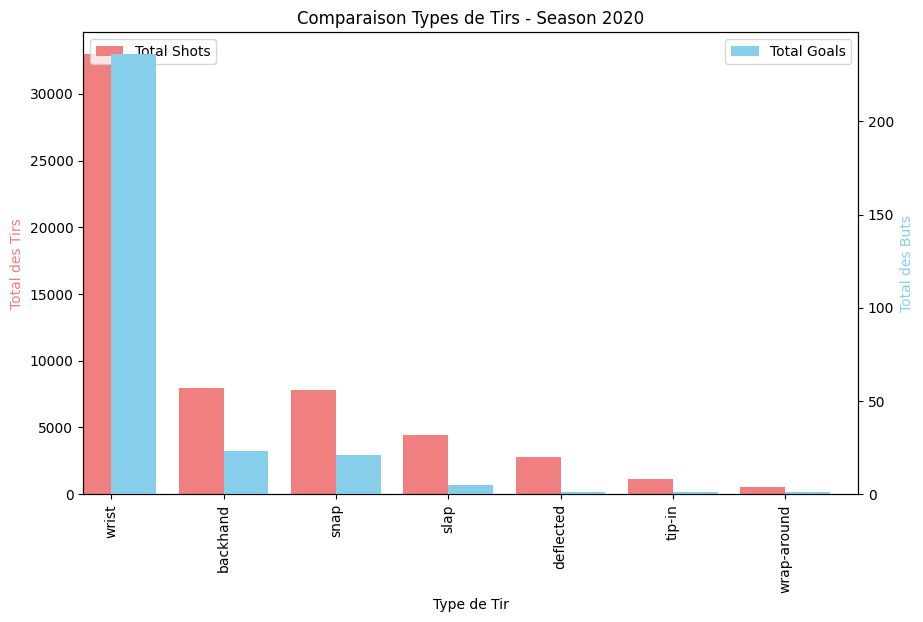

In [ ]:
simple_visualisation.shotsComparaison(dataframes, 2020)

Pour chaque saison entre 2018-19 et 2020-21, un graphique montrant la relation entre la distance à laquelle un tir a été effectué et la chance qu'il s'agisse d'un but et un autre utilise un graphique en ligne pour montrer la tendance de la probabilité de but en fonction des distances regroupées, offrant une vue plus lissée de l'évolution de la probabilité en fonction de la distance.

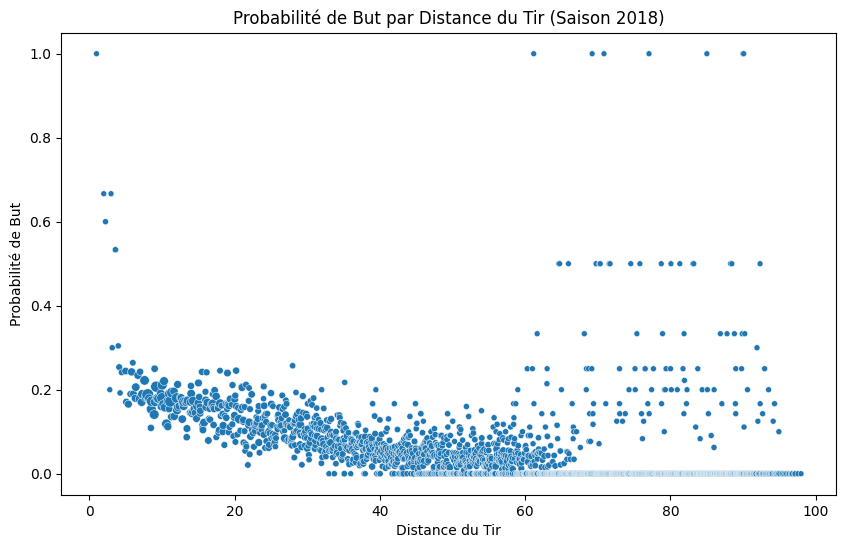

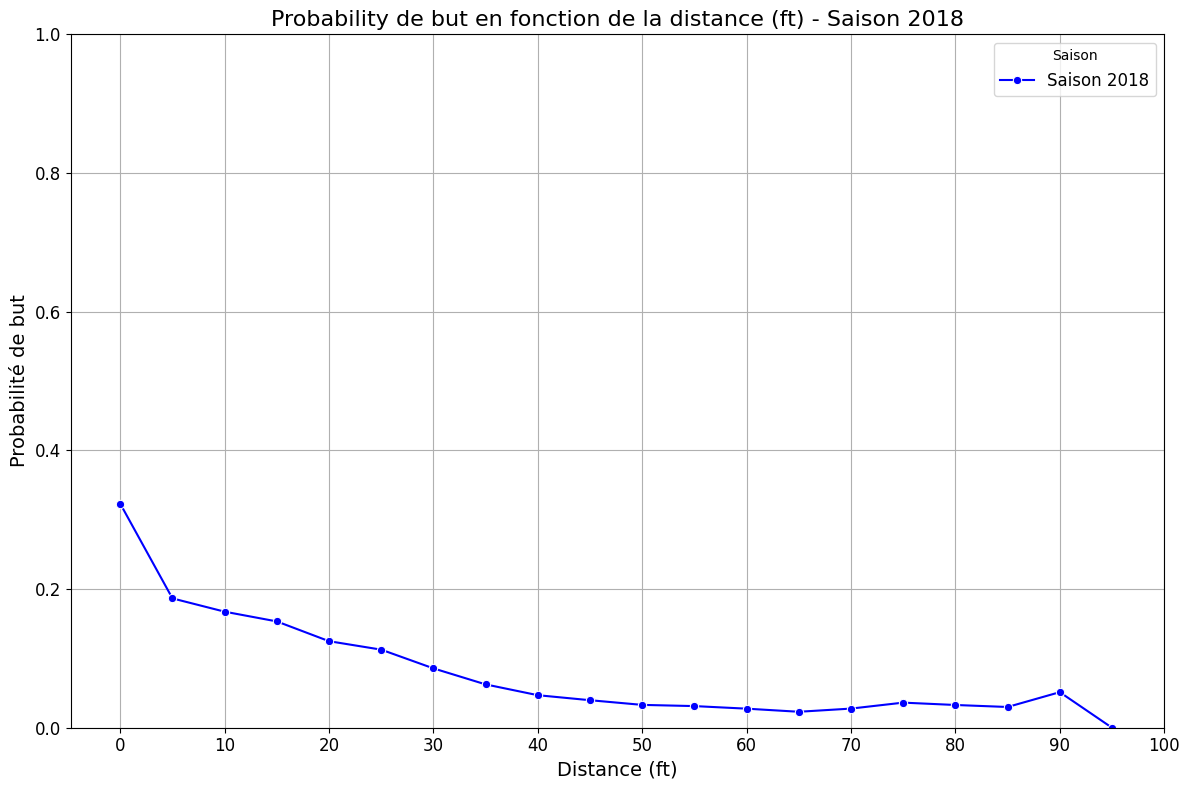

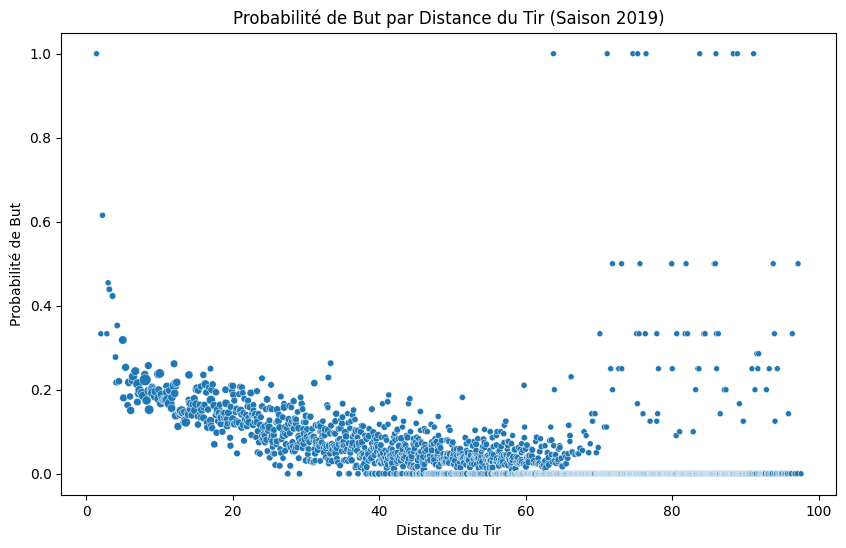

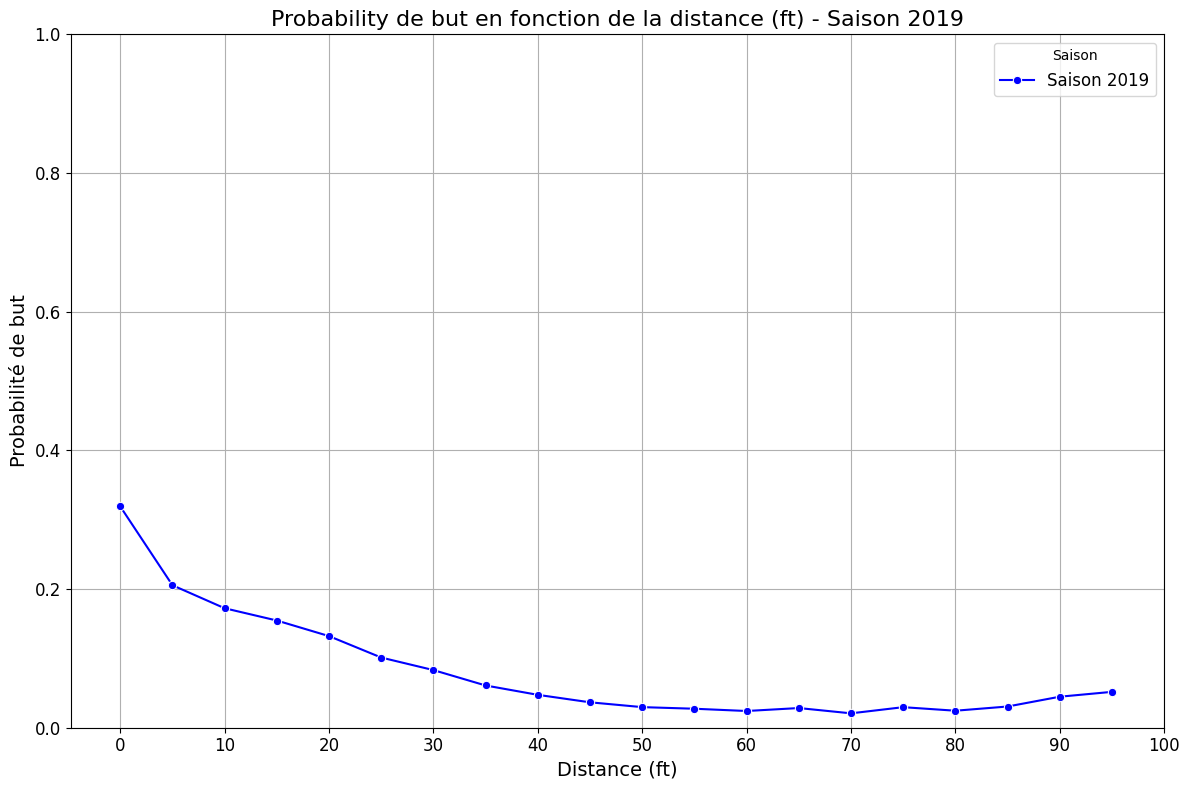

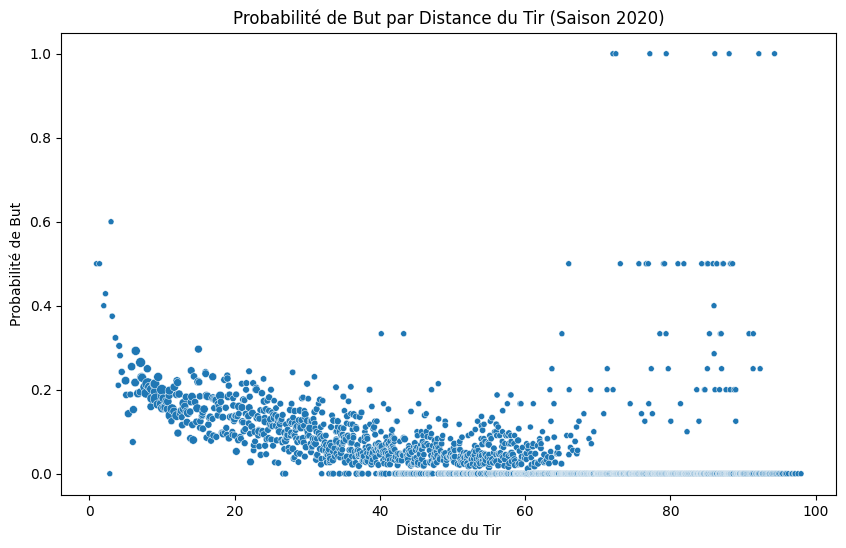

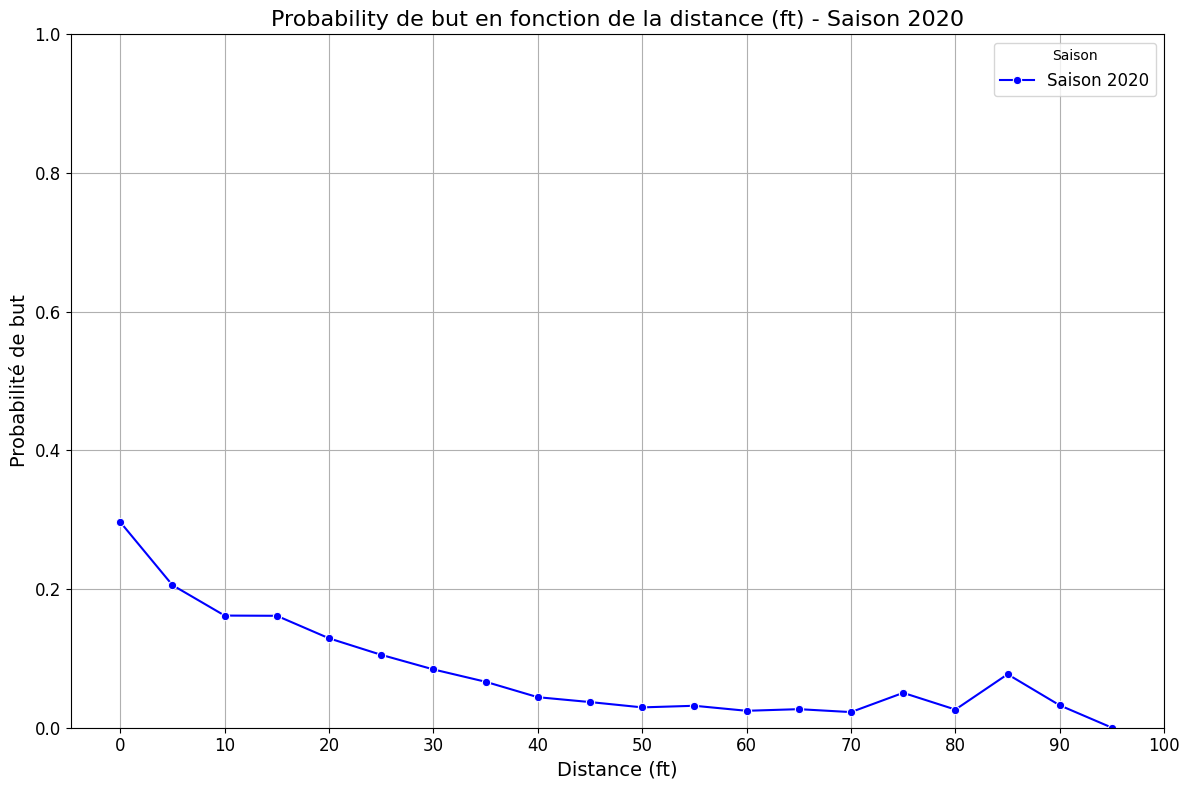

In [ ]:
#Saison 2018
simple_visualisation.distancegoal_relationship(dataframes, 2018)
simple_visualisation.distancegoal_relationship_binned(dataframes, 2018)

#Saison 2019
simple_visualisation.distancegoal_relationship(dataframes, 2019)
simple_visualisation.distancegoal_relationship_binned(dataframes, 2019)

#Saison 2020
simple_visualisation.distancegoal_relationship(dataframes, 2020)
simple_visualisation.distancegoal_relationship_binned(dataframes, 2020)

Graphique qui montre le pourcentage de buts en fonction à la fois de la distance par rapport au filet et de la catégorie de types de tirs. Visualise la relation entre la distance du tir, le type de tir, et la probabilité de but en créant une heatmap.

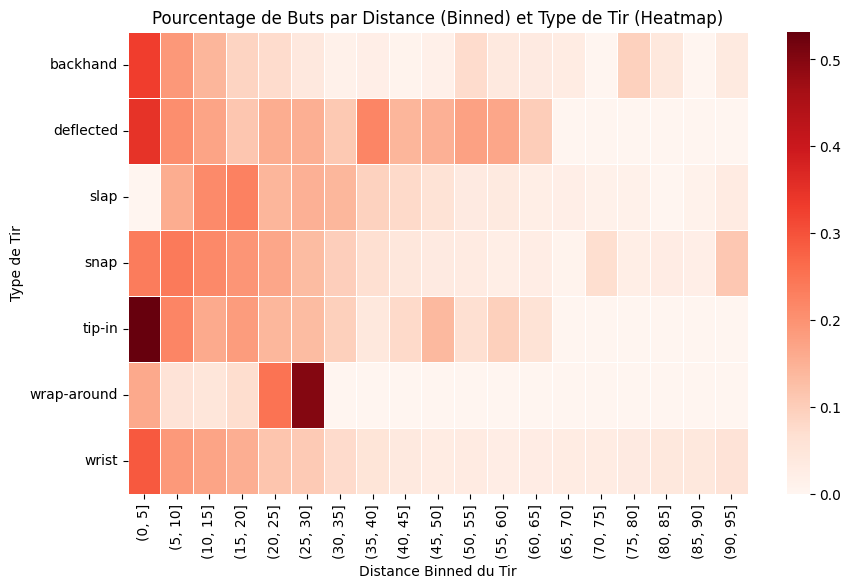

In [ ]:
simple_visualisation.distance_goalpercentage(dataframes, 2018)

5. Visualisations avancées:(30 %)


In [ ]:
advanced_visualisation.widget(dataframes)

interactive(children=(Dropdown(description='Select Year', options=(2016, 2017, 2018, 2019, 2020, 2021, 2022, 2…